In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy.stats as st

def plot_1d_regression(
    x_star,
    gpm,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    gpm      --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    m_star, v_star = gpm.predict(x_star)

    f_lower = (
        m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    f_upper = (
        m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
   
    ax.fill_between(
        x_star.flatten(),
        f_lower.flatten(),
        f_upper.flatten(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.'
    )
    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = gpm.posterior_samples_f(
            x_star,
            num_samples
        )
        ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
        ax.plot([], [], 'r', lw=0.5, label="Posterior samples")

    ax.plot(gpm.X,
            gpm.Y,
            'kx',
            markersize=5,
            markeredgewidth=2,
            label='Observations'
    )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best')
    
    return m_star, v_star


def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None
):
    """Plot the information acquisition function.
    
    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
              
    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    
    The evaluation of the informationa acquisition function
    is as follows:
    
        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )
    
    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )
    
    # THIS CHANGED FROM THE PREVIOUS VERSION
    sigma = np.sqrt(v - gpr.likelihood.variance)
    af_values = alpha(m, sigma, Y.max(), **alpha_params)
    next_id = np.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]
    
    ax2 = ax.twinx()
    ax2.plot(x_star, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel(
        'Maximum Upper Interval',
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        np.linspace(0, af_max, 100),
        color=sns.color_palette()[1],
        linewidth=1
    )
    
def maximize(
    f,
    gpr,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.
    
    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowldege.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
    
    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.
                    
    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        m, sigma2 = gpr.predict(X_design)
        # THIS CHANGED FROM THE PREVIOUS VERSION
        sigma = np.sqrt(sigma2 - gpr.likelihood.variance)
        
        # Evaluate information acquisition function
        af_values = alpha(
            m,
            sigma,
            gpr.Y.max(),
            **alpha_params
        )
        
        # Find best point to include
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        af_all.append(af_values[i])

        # Make observation
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        # Update GPR
        gpr.set_XY(X, y)
        if optimize:
            gpr.optimize()
        
        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                gpr,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all


def mui(m, sigma, ymax, psi=1.96):
    """The maximum upper interval acquisition function."""
    return m + psi * sigma


def poi(m, sigma, ymax, psi=0.):
    """Return the probability of improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    psi   -- A parameter that controls exploration.
    """
    return st.norm.cdf((m - ymax - psi) / sigma)

def ei(m, sigma, ymax):
    """Return the expected improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    u = (m - ymax) / sigma
    ei = sigma * (u * st.norm.cdf(u) + st.norm.pdf(u))
    ei[sigma <= 0.] = 0.
    return ei

# Quantifying Epistemic Uncertainty about the Solution of the Optimization problem

## Objectives

+ Quantify the epistemic uncertainty in the solution of an optimization problem

## Quantifying our Epistemic Uncertainty About the Maximum

Let's start by recreating our working example:

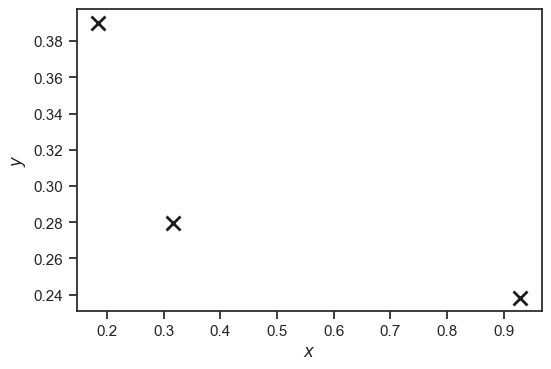

In [2]:
def f(x):
    """A function to optimize."""
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression resulting in the point-predictive distribution:

$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$

where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

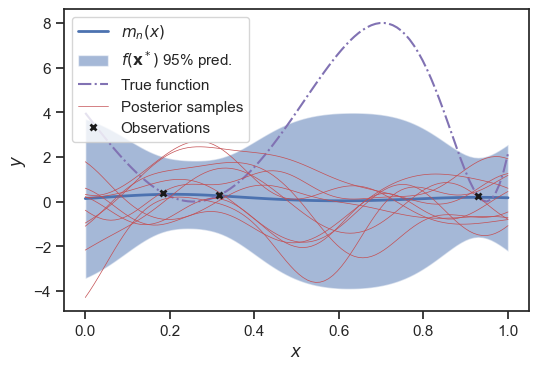

In [3]:
import GPy

k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
x_star = np.linspace(0, 1, 100)[:, None]
plot_1d_regression(x_star, gpr, f_true=f);

Imagine that you have observed data $\mathcal{D}_n$.
How certain are you about the location of the maximum?
If $n$ is small, you can't be too confident?
How do you quantify this epistemic uncertainty?
Notice that the maximum and the location of the maximum are *operators* acting on $f$:

$$
f^* := \max[f] := \max_{\mathbf{x}} f(\mathbf{x}),
$$

and

$$
\mathbf{x}^* := \mathbf{X}^*[f] := \arg\max_{\mathbf{x}} f(\mathbf{x}),
$$

respectively.
So since, we are uncertain about $f$, we will be uncertain about $f^*$ and $\mathbf{x}^*$.
In particular, we would like to somehow quantify the joint probability density $p(\mathbf{x}^*, f^*|\mathcal{D}_n)$.
Here is what is the formal answer:

$$
p(\mathbf{x}^*, f^*|\mathcal{D}_n) = \int \delta(\mathbf{x}^* - \mathbf{X}^*[f])\delta(f^*-\max[f])p(f(\cdot)|\mathcal{D}_n)df(\cdot).
$$

Of course, this is not technically correct because you cannot integrate over a function in this way.
The correct way to write this mathematically is to use conditional expectations:

$$
p(\mathbf{x}^*, f^*|\mathcal{D}_n) = \mathbb{E}\left[\delta(\mathbf{x}^* - \mathbf{X}^*[f])\delta(f^*-\max[f])|\mathcal{D}_n\right],
$$

where the expectation is taken over $f(\cdot)$ conditional on $\mathcal{D}_n$.
In any case, there are two questions:
+ What does this actually mean?
+ How do you compute it?

First, what does it actually mean?
To understand this you need to pay attention to the delta function.
Take for example $\delta(f^* - \max[f])$. What does it do?
Well, it just hits a counter whenever $\max[f]$ matches $f^*$ exactly as you take the expectation over $f(\cdot)$.

Second, how do you compute it?
The simplest way to do this is through sampling.
You basically just sample functions from $p(f(\cdot)|\mathcal{D}_n)$ and you find their maximum the location of the maximum.
Of course, you cannot really sample a function.
You sample the *function values* at a finite, but dense, number of input points and you find the maximum amongst these points.
Once you get these samples, you just look at their histogram.

Ok, let's do it for our working example:

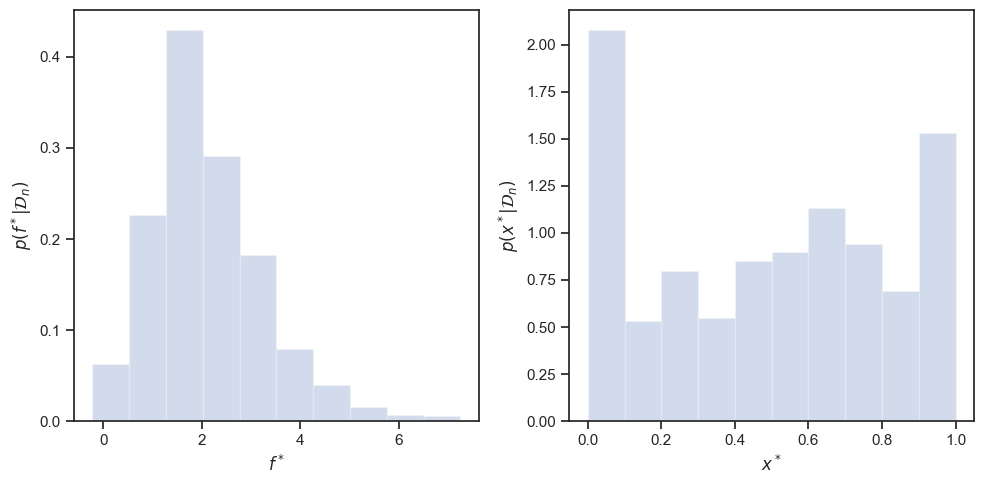

In [4]:
def plot_max_and_argmax(gpr, X_design, n_samples=1000):
    """Plot histograms of the max and argmax of the function represented by the model gpr.
    
    Arguments
    gpr      -- A trained Gaussian process object.
    X_design -- A set of points to evaluate the response on.
    
    Keyword Arguments
    n_samples -- The number of samples to take to make the histograms.
    """
    f_samples = gpr.posterior_samples_f(
        X_design,
        size=n_samples
    )[:, 0, :]
    max_f_samples = np.max(f_samples, axis=0)
    x_star_samples = X_design[np.argmax(f_samples, axis=0), 0]
    
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    ax[0].hist(max_f_samples, density=True, alpha=0.25)
    ax[0].set_xlabel('$f^*$')
    ax[0].set_ylabel('$p(f^*|\mathcal{D}_n)$')
    
    ax[1].hist(x_star_samples, density=True, alpha=0.25)
    ax[1].set_xlabel('$x^*$')
    ax[1].set_ylabel('$p(x^*|\mathcal{D}_n)$')
    
    plt.tight_layout()
    
    return fig, ax

plot_max_and_argmax(gpr, x_star);

Let's do a few iterations ofour optimization algorithm and repeat that plot.

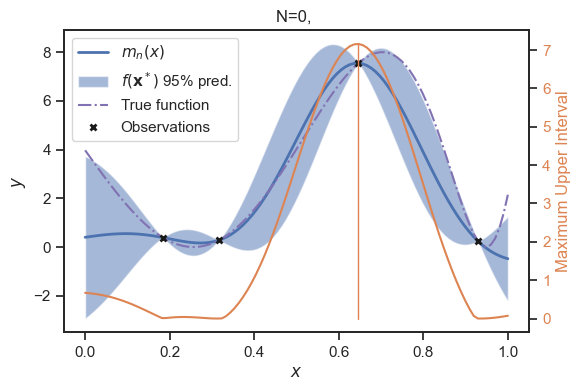

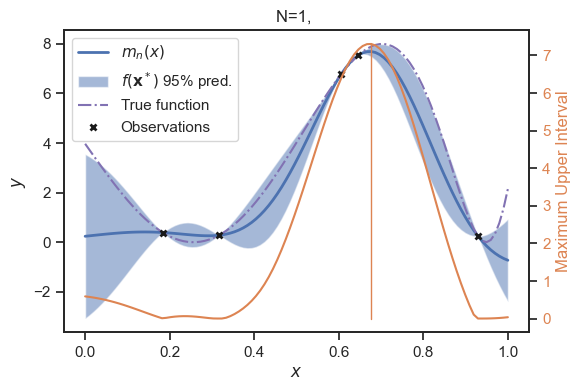

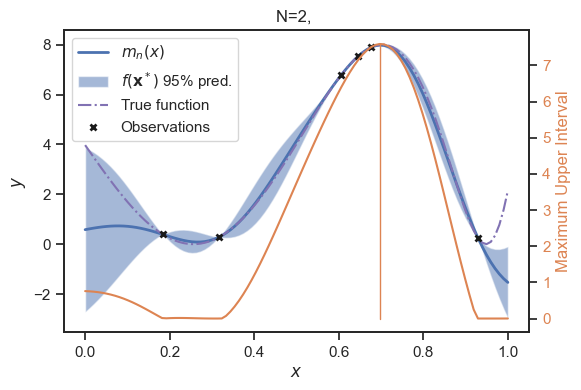

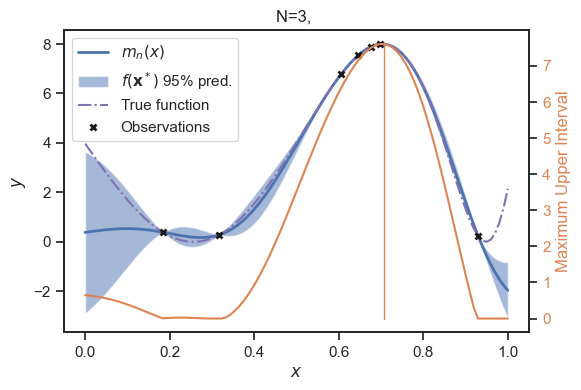

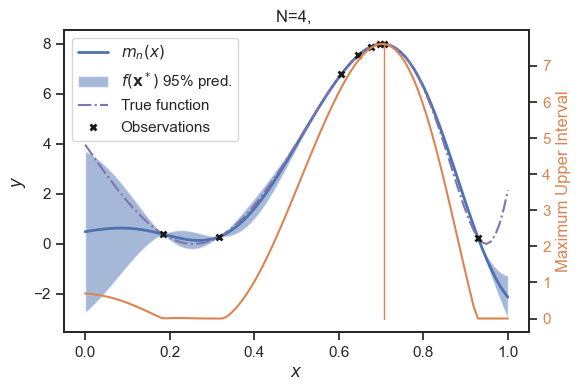

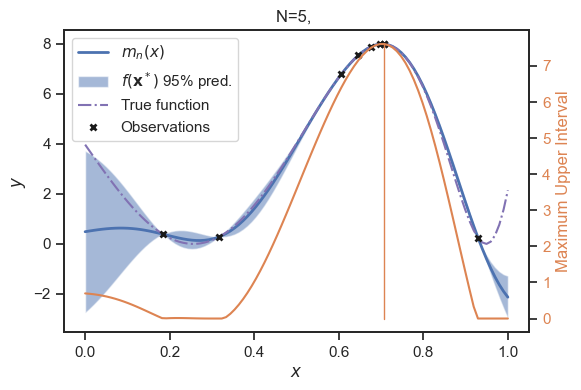

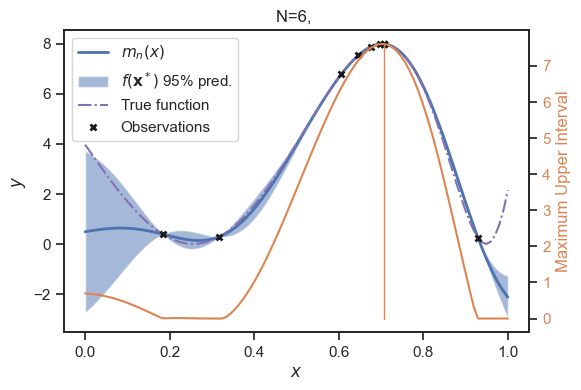

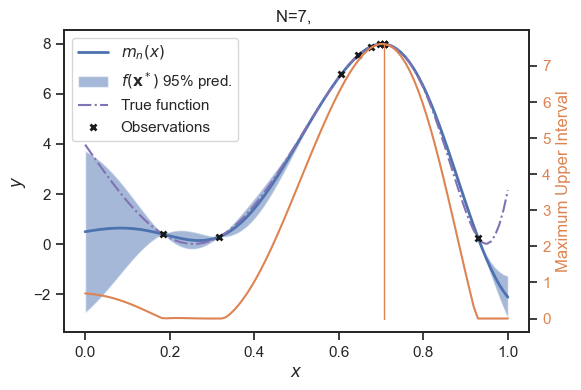

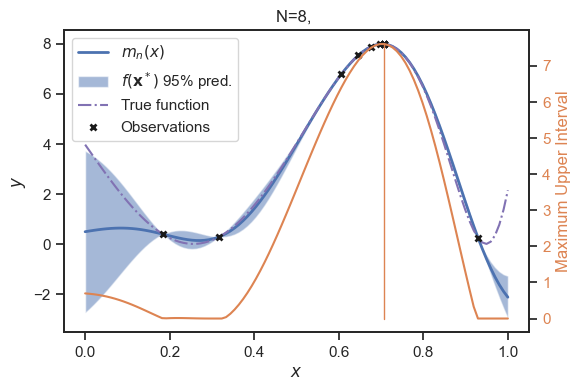

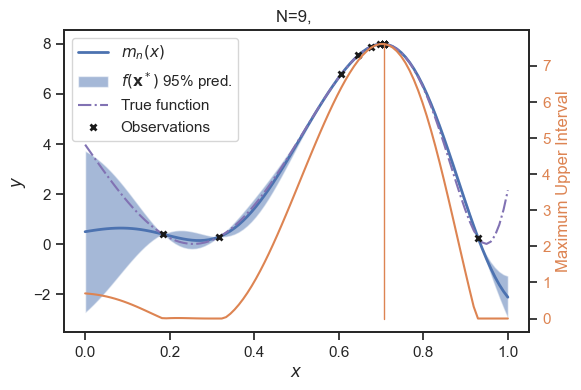

In [5]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(
    f,
    gpr,
    x_star,
    ei,
    max_it=10,
    plot=1
)

Here it is again:

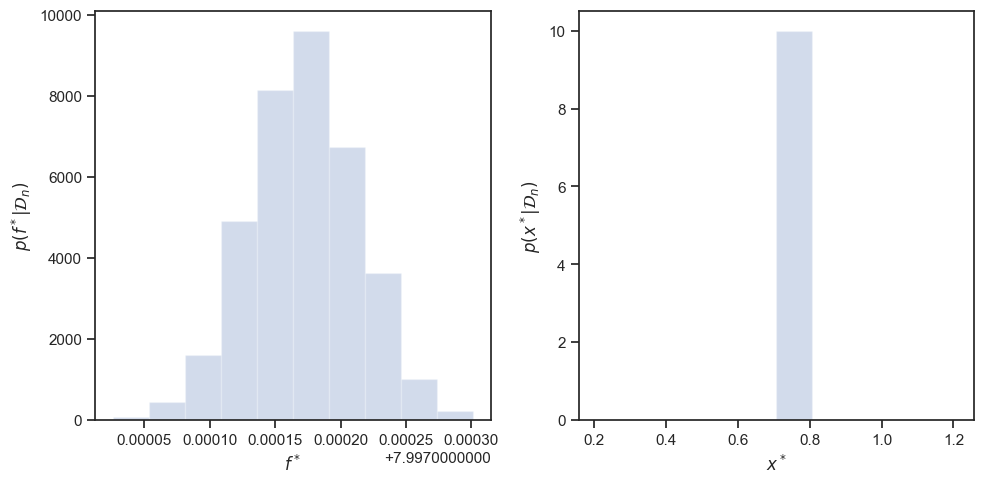

In [6]:
plot_max_and_argmax(gpr, x_star);

### Questions
+ How does the epistemic uncertainty about the optimization problem change when you decrease the number of initial samples?

+ Try changing the number of initial samples to a very small number? Does the algorithm work?